In [12]:
from langchain_ollama import ChatOllama
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, BaseMessage, AIMessage
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import interrupt, Command
from database_langgraph_frontend import user_input


In [13]:
llm = ChatOllama(model="llama3")

In [14]:
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

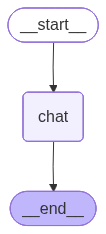

In [32]:
def chat_node(state: ChatState):

    decision = interrupt({
        "type": "approval",
        "reason": "Model is about to answer a user question",
        "question": state["messages"][-1].content,
        "instruction": "Approve this question? yes/no"
    })

    print(decision['approved'])
    if decision['approved']== 'no':
        return {"messages": [AIMessage(content="Not approved.")]}
    else:
        response = llm.invoke(state['messages'])
        return {"messages": [response]}


# Build the graph: START -> chat -> END
graph = StateGraph(ChatState)

graph.add_node("chat", chat_node)

graph.add_edge(START,"chat")
graph.add_edge("chat", END)

# Checkpointer is required for interrupts
checkpointer = MemorySaver()

# Compile the app
app = graph.compile(checkpointer=checkpointer)

app


In [33]:

#Create a new thread if for this conversation
config = {"configurable": {"thread_id": "1234"}}

#---- STEP 1 : user asks a question -----
initial_input = {
    "messages": [
        ("user", "Explain gradient descent in very simple terms")
    ]
}


# INvoke the graph for the first time
result = app.invoke(initial_input, config=config)
result

{'messages': [HumanMessage(content='Explain gradient descent in very simple terms', additional_kwargs={}, response_metadata={}, id='db9755dd-e636-4ad0-bcec-fb5cf03b5c29')],
 '__interrupt__': [Interrupt(value={'type': 'approval', 'reason': 'Model is about to answer a user question', 'question': 'Explain gradient descent in very simple terms', 'instruction': 'Approve this question? yes/no'}, id='2c75d05ba90abc74a8c41e901ccbc25d')]}

In [34]:
message = result["__interrupt__"][0].value
message

{'type': 'approval',
 'reason': 'Model is about to answer a user question',
 'question': 'Explain gradient descent in very simple terms',
 'instruction': 'Approve this question? yes/no'}

In [35]:
user_input = input(f"\nBackend message - {message} \n Approve this question? yes/no")

In [36]:
user_input

'yes'

In [38]:

final_result = app.invoke(
    Command(resume={"approved": user_input}),
    config=config,
)

In [39]:
print(final_result)

{'messages': [HumanMessage(content='Explain gradient descent in very simple terms', additional_kwargs={}, response_metadata={}, id='db9755dd-e636-4ad0-bcec-fb5cf03b5c29'), AIMessage(content='Gradient Descent!\n\nImagine you\'re trying to find the perfect coffee shop. You have a vague idea where it might be, but you don\'t know exactly which street to walk down or when to turn left/right.\n\n**Goal:** Find the perfect coffee shop with the best coffee and atmosphere.\n\n**Problem:** The coffee shops are scattered all over the city, and you need to find the right one.\n\n**Solution:** You start walking in a random direction, but then you look at your phone (your "model") and see how far away you are from each known coffee shop. Your model gives you feedback: "Hey, if you walk 2 blocks north and turn left, you\'ll get closer to the best coffee shop."\n\n**Gradient Descent:** You take a small step in that direction (2 blocks north and left) and then look at your phone again. If you\'re stil